In [1]:
### Mount Notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive')
# change the working directory to the Drive root
%cd /content/drive/My\ Drive/Colab\ Notebooks/deep_research_from_scratch-main

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/deep_research_from_scratch-main


In [2]:
!pip install --quiet -U langchain-google-genai langchain_core langgraph langchain langsmith tavily-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.5/378.5 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 15.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelang

In [3]:
!pip install --quiet python-dotenv

In [4]:
from dotenv import load_dotenv
load_dotenv(".env")

True

In [ ]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Research Agent

*The goal of research is to gather the context requested by the research brief.*

Here is our overall research flow:

![image (2).webp](attachment:163874fb-f993-4fcd-b5e0-f5f779212a55.webp)

Research is an open‑ended task. The best strategy to answer a user request can't be easily known in advance.

Requests can require different research strategies and varying levels of search depth. Consider this request:

> *"Compare these two products"*

Comparisons typically benefit from search on each product, followed by a synthesis step to compare them. Now, consider this one:

> *"Give me the top candidates for my job posting"*

Listing and ranking requests typically require open-ended search, followed by a synthesis and ranking.

[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) are well suited to research because they can flexibly apply different strategies, using intermediate results to guide their exploration.

The agent follows a [simple yet effective pattern](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent):

1. **LLM Decision Node**: Analyzes the current state and decides whether to make tool calls or provide a final response
2. **Tool Execution Node**: Executes search tools when the LLM determines more information is needed
3. **Research Compression Node**: Summarizes and compresses research findings for efficient processing
4. **Routing Logic**: Determines workflow continuation based on LLM decisions

![Screenshot 2025-07-16 at 1.07.45 PM.png](attachment:3ceab77d-beb4-4189-be07-0634f1f72202.png)

### Prompt

First, we'll define a prompt that instructs our agent to use available search tools.

To prevent excessive tool calls and maintain research focus, we use [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

#### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

#### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

#### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find?
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

#### Results
These techniques transform problematic research behavior like:
```
"best coffee shops SF" → "Saint Frank Coffee details" → "Sightglass Coffee details" → "Ritual Coffee details" → etc. (20+ searches)
```

Into efficient patterns like:
```
"best coffee shops SF" → ThinkTool(analyze results) → "SF specialty coffee quality ratings" → ThinkTool(assess completeness) → provide answer (3-5 searches total)
```

The key insight: **Think like a human researcher with limited time** - this prevents the "spin-out problem" where agents continue searching indefinitely.

In [5]:
from notebooks.utils import show_prompt
from src.deep_research_from_scratch.prompts import research_agent_prompt
show_prompt(research_agent_prompt, "Research Agent Instructions")

╭────────────────────────────────────────── Research Agent Instructions ──────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

### State and Schemas

We'll create the agent state object.


In [6]:
%%writefile ./src/deep_research_from_scratch/state_research.py

"""
State Definitions and Pydantic Schemas for Research Agent

This module defines the state objects and structured schemas used for
the research agent workflow, including researcher state management and output schemas.
"""

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# ===== STATE DEFINITIONS =====

class ResearcherState(TypedDict):
    """
    State for the research agent containing message history and research metadata.

    This state tracks the researcher's conversation, iteration count for limiting
    tool calls, the research topic being investigated, compressed findings,
    and raw research notes for detailed analysis.
    """
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    """
    Output state for the research agent containing final research results.

    This represents the final output of the research process with compressed
    research findings and all raw notes from the research process.
    """
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    summary: str = Field(description="Concise summary of the webpage content")
    key_excerpts: str = Field(description="Important quotes and excerpts from the content")

Overwriting ./src/deep_research_from_scratch/state_research.py


Now, we'll define our research tool.  

#### Tavily SDK Integration

We'll use the [Tavily SDK](https://docs.tavily.com/sdk/python/reference) to perform web searches.

Tavily is a search engine optimized for AI applications with a generous free tier, providing:
- Real-time web search results
- Content extraction and summarization
- Domain filtering and result ranking
- Async support for performance

#### Alternative Web Content Sources

While we use Tavily's search API in this tutorial, there are several other excellent options for web content extraction:

- **[Tavily Extract](https://docs.tavily.com/documentation/api-reference/endpoint/extract)**: Tavily's dedicated content extraction endpoint that can extract and clean content from specific URLs without performing searches
- **[Jina Reader](https://jina.ai/reader/)**: A powerful web content extraction service that converts web pages to clean, LLM-friendly text by simply prepending `https://r.jina.ai/` to any URL
- **[Firecrawl](https://www.firecrawl.dev/)**: A comprehensive web scraping platform that converts websites into clean markdown or structured data, with advanced features like JavaScript rendering and sitemap crawling

Each tool has different strengths: Tavily excels at search-first workflows, Jina Reader offers the simplest URL-to-text conversion, and Firecrawl provides the most comprehensive web scraping capabilities for complex sites.

####  LangChain Tools

We'll convert our Tavily search function into a [LangChain tool](https://python.langchain.com/docs/concepts/tools/) using the `@tool` decorator. This enables:
- Automatic schema generation for the LLM
- Integration with LangChain's agent framework
- Standardized tool calling interface
- Type validation and documentation

Note that some of the arguments are noted as [InjectedToolArg](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.base.InjectedToolArg.html). These are not included in the tool schema sent to the LLM, and instead are injected during execution. This gives us the flexibility to inject values at runtime, but does not burden the language model with the responsibility of managing these arguments.

In [12]:
%%writefile ./src/deep_research_from_scratch/utils.py

"""Research Utilities and Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""

from pathlib import Path
from datetime import datetime
from typing_extensions import Annotated, List, Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import TavilyClient

from src.deep_research_from_scratch.state_research import Summary
from src.deep_research_from_scratch.prompts import summarize_webpage_prompt

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def get_current_dir() -> Path:
    """Get the current directory of the module.

    This function is compatible with Jupyter notebooks and regular Python scripts.

    Returns:
        Path object representing the current directory
    """
    try:
        return Path(__file__).resolve().parent
    except NameError:  # __file__ is not defined
        return Path.cwd()

# ===== CONFIGURATION =====

#summarization_model = init_chat_model(model="openai:gpt-4.1-mini")
summarization_model = init_chat_model("gemini-2.5-flash-lite", model_provider="google_genai")
tavily_client = TavilyClient()

# ===== SEARCH FUNCTIONS =====

def tavily_search_multiple(
    search_queries: List[str],
    max_results: int = 3,
    topic: Literal["general", "news", "finance"] = "general",
    include_raw_content: bool = True,
) -> List[dict]:
    """Perform search using Tavily API for multiple queries.

    Args:
        search_queries: List of search queries to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        List of search result dictionaries
    """

    # Execute searches sequentially. Note: yon can use AsyncTavilyClient to parallelize this step.
    search_docs = []
    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic
        )
        search_docs.append(result)

    return search_docs

def summarize_webpage_content(webpage_content: str) -> str:
    """Summarize webpage content using the configured summarization model.

    Args:
        webpage_content: Raw webpage content to summarize

    Returns:
        Formatted summary with key excerpts
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)

        # Generate summary
        summary = structured_model.invoke([
            HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content,
                date=get_today_str()
            ))
        ])

        # Format summary with clear structure
        formatted_summary = (
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"
        )

        return formatted_summary

    except Exception as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content

def deduplicate_search_results(search_results: List[dict]) -> dict:
    """Deduplicate search results by URL to avoid processing duplicate content.

    Args:
        search_results: List of search result dictionaries

    Returns:
        Dictionary mapping URLs to unique results
    """
    unique_results = {}

    for response in search_results:
        for result in response['results']:
            url = result['url']
            if url not in unique_results:
                unique_results[url] = result

    return unique_results

def process_search_results(unique_results: dict) -> dict:
    """Process search results by summarizing content where available.

    Args:
        unique_results: Dictionary of unique search results

    Returns:
        Dictionary of processed results with summaries
    """
    summarized_results = {}

    for url, result in unique_results.items():
        # Use existing content if no raw content for summarization
        if not result.get("raw_content"):
            content = result['content']
        else:
            # Summarize raw content for better processing
            content = summarize_webpage_content(result['raw_content'])

        summarized_results[url] = {
            'title': result['title'],
            'content': content
        }

    return summarized_results

def format_search_output(summarized_results: dict) -> str:
    """Format search results into a well-structured string output.

    Args:
        summarized_results: Dictionary of processed search results

    Returns:
        Formatted string of search results with clear source separation
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."

    formatted_output = "Search results: \n\n"

    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        formatted_output += "-" * 80 + "\n"

    return formatted_output

# ===== RESEARCH TOOLS =====

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> str:
    """Fetch results from Tavily search API with content summarization.

    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')

    Returns:
        Formatted string of search results with summaries
    """
    # Execute search for single query
    search_results = tavily_search_multiple(
        [query],  # Convert single query to list for the internal function
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    )

    # Deduplicate results by URL to avoid processing duplicate content
    unique_results = deduplicate_search_results(search_results)

    # Process results with summarization
    summarized_results = process_search_results(unique_results)

    # Format output for consumption
    return format_search_output(summarized_results)

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What crucial information is still missing?
    - Before concluding research: Can I provide a complete answer now?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
    """
    return f"Reflection recorded: {reflection}"

Overwriting ./src/deep_research_from_scratch/utils.py


### Research Agent

#### Overview

Our research agent perform iterative tool-calling to search for information.

The agent follows a [simple yet effective pattern](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent):

1. **LLM Decision Node**: Analyzes the current state and decides whether to make tool calls or provide a final response
2. **Tool Execution Node**: Executes search tools when the LLM determines more information is needed
3. **Research Compression Node**: Summarizes and compresses research findings for efficient processing
4. **Routing Logic**: Determines workflow continuation based on LLM decisions

#### Context Engineering Strategy

We apply **context engineering** in two places following the principles outlined in [Context Engineering for Agents](https://blog.langchain.com/context-engineering-for-agents/):

#### 1. Webpage Content Summarization
Raw search results often contain excessive noise (navigation, ads, boilerplate content). Our `summarize_webpage_content()` function:
- Uses structured output to extract key information and relevant excerpts
- Filters out irrelevant content while preserving factual details
- Compresses lengthy articles into focused summaries
- Maintains source attribution for credibility

#### 2. Research Result Compression  
As the agent performs multiple searches, the conversation context grows rapidly. Our `compress_research()` function:
- Synthesizes findings from multiple tool calls into cohesive insights
- Extracts raw notes for detailed analysis while maintaining compressed summaries
- Reduces token usage for subsequent LLM calls
- Preserves essential information for report writing

This dual-layer context engineering allows the agent to process extensive information efficiently while maintaining high-quality research output.

#### 3. Performing Careful Compression
[Compression](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) [is risky](https://cognition.ai/blog/dont-build-multi-agents)! We need to be very careful about loosing valuable information. We'll use an LLM for compression with instructions in a system prompt that comes before a potentially long, token-heavy trajectory of multiple tool calls. The long context can cause the compression LLM [to loose sight of the task instructions](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), leading to generic summaries that loose information. So, we reinforce the compression task by adding a `compress_research_human_message` that:
- Explicitly restates the original research topic at compression time
- Reminds the model to preserve ALL information relevant to the specific question
- Emphasizes that comprehensive findings are critical for final report generation
- Prevents task drift during the compression phase

#### 4. Output Token Management
Research compression can generate long outputs. We need to sure that they do not exceed model token limits, which can cause truncated responses that cut off mid-sentence (as seen with "**Sextant Coffee Ro" being cut off). As an example, [GPT-4.1 has output limit of up to 33k tokens](https://openai.com/index/gpt-4-1/) and [Claude4 sonnet supports 64k](https://www.anthropic.com/claude/sonnet).

Model SDKs / LangChain integrations may cap this (e.g., [to `1024` tokens in the case of Claude](https://github.com/langchain-ai/langchain/blob/master/libs/partners/anthropic/langchain_anthropic/chat_models.py#L1149C5-L1149C15)). Simply ensure that max tokens is set to ensure complete output. This prevents incomplete compression outputs and ensures full research findings are preserved. Test compression quality vs latency for different models. For example:

* Claude4-Sonnet 99s latency for compression ([trace](https://smith.langchain.com/public/ca006e79-8838-47eb-9d8c-c7fe7d57a6bc/r))
* GPT-4.1 38s latency for compression ([trace](https://smith.langchain.com/public/ca846b08-7501-43a0-bbda-735d4b07ab0a/r))

In [13]:
%%writefile ./src/deep_research_from_scratch/research_agent.py

"""Research Agent Implementation.

This module implements a research agent that can perform iterative web searches
and synthesis to answer complex research questions.
"""

from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model

from src.deep_research_from_scratch.state_research import ResearcherState, ResearcherOutputState
from src.deep_research_from_scratch.utils import tavily_search, get_today_str, think_tool
from src.deep_research_from_scratch.prompts import research_agent_prompt, compress_research_system_prompt, compress_research_human_message

# ===== CONFIGURATION =====

# Set up tools and model binding
tools = [tavily_search, think_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize models
#model = init_chat_model(model="anthropic:claude-sonnet-4-20250514")
model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")
model_with_tools = model.bind_tools(tools)
#summarization_model = init_chat_model(model="openai:gpt-4.1-mini")
summarization_model = init_chat_model("gemini-2.5-flash-lite", model_provider="google_genai")
#compress_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000
compress_model = init_chat_model(model="gemini-2.5-flash-lite", model_provider="google_genai", max_tokens=64000)

# ===== AGENT NODES =====

def llm_call(state: ResearcherState):
    """Analyze current state and decide on next actions.

    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information

    Returns updated state with the model's response.
    """
    return {
        "researcher_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt)] + state["researcher_messages"]
            )
        ]
    }

def tool_node(state: ResearcherState):
    """Execute all tool calls from the previous LLM response.

    Executes all tool calls from the previous LLM responses.
    Returns updated state with tool execution results.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls

    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))

    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]

    return {"researcher_messages": tool_outputs}

def compress_research(state: ResearcherState) -> dict:
    """Compress research findings into a concise summary.

    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for the supervisor's decision-making.
    """

    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("researcher_messages", []) + [HumanMessage(content=compress_research_human_message)]
    response = compress_model.invoke(messages)

    # Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"],
            include_types=["tool", "ai"]
        )
    ]

    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

# ===== ROUTING LOGIC =====

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """Determine whether to continue research or provide final answer.

    Determines whether the agent should continue the research loop or provide
    a final answer based on whether the LLM made tool calls.

    Returns:
        "tool_node": Continue to tool execution
        "compress_research": Stop and compress research
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we have a final answer
    return "compress_research"

# ===== GRAPH CONSTRUCTION =====

# Build the agent workflow
agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# Add nodes to the graph
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_research", compress_research)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node", # Continue research loop
        "compress_research": "compress_research", # Provide final answer
    },
)
agent_builder.add_edge("tool_node", "llm_call") # Loop back for more research
agent_builder.add_edge("compress_research", END)

# Compile the agent
researcher_agent = agent_builder.compile()

Overwriting ./src/deep_research_from_scratch/research_agent.py


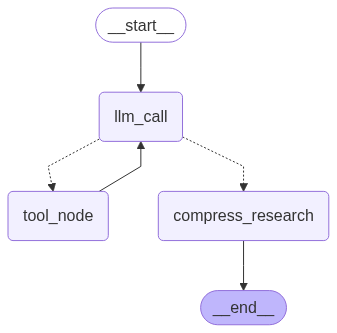

In [14]:
from IPython.display import Image, display
from src.deep_research_from_scratch.research_agent import researcher_agent

# Show the agent
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

In [15]:
# Run the agent
from notebooks.utils import format_messages
from langchain_core.messages import HumanMessage

# Example brief
research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area,
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as
of July 2025."""

result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['researcher_messages'])

Failed to summarize webpage: 'NoneType' object has no attribute 'summary'
Failed to summarize webpage: 'NoneType' object has no attribute 'summary'


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "best coffee shops San Francisco coffee quality reviews"                                             │
│ }                                                                                                               │
│    ID: 45dd56e9-3bcb-4529-9080-4dfa9d4b8fd0                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: 16 Best Coffee Shops In San Francisco - Tasting Table ---                                         │
│ URL: https://www.tastingtable.com/1479970/best-coffee-shops-san-francisco/                                      │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ This webpage provides a guide to 16 of the best coffee shops in San Francisco, highlighting their unique        │
│ offerings, atmosphere, and commitment to quality coffee. It features a variety of cafes, from well-known chains │
│ to independent shops, each with its own distinct character and specialties. The list includes detailed          │
│ descriptions of popular drinks, addresses, contact information, and insights into the sourcing and roasting     │
│ practices of each establishment. Notable mentions include Compton's Coffee House for its Lavender Latte, Red    │
│ Bay Coffee for its sustainably sourced specialty coffees and community focus, Ritual for its strong,            │
│ high-quality coffee and home brewing tools, and Mazarine for its French-inspired ambiance and pour-over         │
│ selections. Other highlighted spots like Blue Bottle Coffee, Sightglass Coffee, Wrecking Ball Coffee Roasters,  │
│ Equator Coffee, The Scullery, Sextant Coffee Roasters, Hey Neighbor Cafe, Java on Ocean, Philz Coffee, Saint    │
│ Frank Coffee, Flywheel Coffee Roasters, and Andytown Coffee are praised for their unique flavors, cozy          │
│ environments, and dedication to the craft of coffee.                                                            │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ From popular chains to independently owned cafes, there's quite a range of places to choose from. One thing     │
│ they all have in common, however, is the attention to care and quality that goes into roasting and serving the  │
│ best coffee out there., Compton's Coffee House is a gem of a coffee shop, with one location on the popular      │
│ Fillmore Street in Lower Pacific Heights, and the other in North Beach., Red Bay is renowned in the Bay Area    │
│ for its mission which is rooted in efforts to diversify the coffee production community., Ritual ensures that   │
│ customers are drinking only the best by paying for specialty-grade coffees sourced by smaller farmers.,         │
│ Mazarine brings Paris to San Francisco with its French-inspired cafe and tasty coffees., Blue Bottle            │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Ritual Coffee Roasters San Francisco coffee quality reviews sourcing"                               │
│ }                                                                                                               │
│    ID: 3d30dad1-857f-48c5-99e8-bdc8398a3ac0                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Review: Ritual Coffee Roasters - Condé Nast Traveler ---                                          │
│ URL: https://www.cntraveler.com/restaurants/san-francisco/ritual-coffee-roasters                                │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ [Skip to main content](#main-content)                                                                           │
│                                                                                                                 │
│                                                                                                                 │
│ ‎                                                                                                                │
│ [Subscribe for ~~$2.50~~ $1 per month + get a                                                                   │
│ tote!](https://www.cntraveler.com/v2/offers/cnt_edit?source=Site_0_HCL_CNT_LINK_BANNER_0_CNT_CONTROL_2025_ZZ)   │
│                                                                                                                 │
│ [North America](/destinations/north-america)                                                                    │
│                                                                                                                 │
│ [United States](/tag/united-states)                                                                             │
│                                                                                                                 │
│ [California](/tag/california)                                                                                   │
│                                                                                                                 │
│ [San Francisco](/destinations/san-francisco)                                                                    │
│                                                                                                                 │
│ # Review: Ritual Coffee Roasters                                                                                │
│                                                                                                                 │
│ Design-driven shop with pour-over coffee made using a V60 dripper.                                              │
│                                                                                                                 │
│ Courtesy Ritual Coffee Roasters                                                                                 │
│                                                                                                                 │
│ ## Photos                                                                                                       │
│                                                                                                                 │
│ Reviewed by                                                                                                     │
│ [Lexi Pandell](/contributors/lexi-pandell)                                                                      │
│                                                       

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Blue Bottle Coffee San Francisco coffee quality sourcing reviews certifications"                    │
│ }                                                                                                               │
│    ID: 66ddf6a2-c627-4c9f-bab7-5dfe842fb520                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Responsible Coffee Sourcing at Blue Bottle ---                                                    │
│ URL: https://blog.bluebottlecoffee.com/posts/responsibly-sourced                                                │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ Blue Bottle Coffee renewed its responsible coffee sourcing credentials in 2024, with 94% of purchases achieving │
│ Enveritas's Responsibly Sourced mark and another 6% verified or certified as compliant with the Coffee          │
│ Sustainability Reference Code. The company supports sustainable sourcing through price premiums, community      │
│ projects, and a partnership with Enveritas since 2020. Enveritas verifies farm conditions against               │
│ sustainability standards, providing data for producers and Blue Bottle to identify areas for improvement. Blue  │
│ Bottle first achieved the Enveritas mark in 2023, highlighting their commitment to traceability and continuous  │
│ improvement in sustainable coffee practices.                                                                    │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ In 2024, Blue Bottle Coffee renewed its responsible coffee sourcing credentials, achieving Enveritas's          │
│ Responsibly Sourced mark for 94 percent of purchases with another 6 percent verified or certified as compliant  │
│ with the Coffee Sustainability Reference Code. Since 2020, Blue Bottle has worked to protect and deepen this    │
│ commitment to sustainable coffee sourcing through data. Enveritas verifies conditions on coffee farms in        │
│ regions or supply streams where Blue Bottle sources coffee, helping us to collaborate with producers to drive   │
│ continuous improvement around core sustainability metrics. In 2023, Blue Bottle first achieved the Enveritas    │
│ Responsibly Sourced mark, an accomplishment made possible by investing in projects to remediate risk in each    │
│ sourcing region. Today, Blue Bottle’s responsible sourcing credentials reflect our commitment to traceability   │
│ and continuous improvement in sustainable coffee practices.                                                     │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Our Coffee ---                           

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Ritual Coffee Roasters San Francisco coffee tasting notes expert reviews"                           │
│ }                                                                                                               │
│    ID: 1229a54b-119f-4bb2-a6e3-669a32848ddd                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Review: Ritual Coffee Roasters Day Drinker Seasonal Espresso ... ---                              │
│ URL: https://coffeecantata.co/?p=2474                                                                           │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ This webpage is a review of Ritual Coffee Roasters Day Drinker Seasonal Espresso, purchased from Maverick       │
│ Coffee in Scottsdale, Arizona. The reviewer initially encountered Ritual Coffee Roasters in Los Angeles and was │
│ impressed by their quality. Despite finding Ritual                                                              │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ This isn’t a normal espresso – I’m actually pretty impressed that Maverick was pulling this as their espresso   │
│ that day since it isn’t what I would consider to be a “workhorse” sort of espresso. It’s quite special!         │
│ Favorite parameters for this blend: 204 degrees F, 17 grams in, 32 grams out, 26 second extraction. Something   │
│ this complex needs to be enjoyed on its own! But, I did make a couple of lattes for Shutterbug with this stuff. │
│ His comment was that it didn’t taste like coffee. Good flavor, but definitely not a “normal” latte. This was a  │
│ surprise. I had expected this cup to taste like a muted version of the espresso, but the main flavor I got in   │
│ the cup was of toasted marshmallow. The finish was of sweet orange, but the overall taste took me to a          │
│ campfire. Not what I expected at all but hugely enjoyable! Lots of surprises in this cup for adventurous        │
│ palates. If you’re used to nutty, dark, moody espresso, this brew will be perplexing to you, but don’t knock it │
│ ’til you try it! I don’t think this is an espresso you can quaff mindlessly – it’ll make you think. And I sure  │
│ enjoy thinking. From the roaster: Rum-soaked pears, candied ginger, star anise, chocolate covered oranges       │
│ (Damn, I need to up my game in the tasting department!! I can definitely see the pear and candied ginger now    │
│ that they mention it.)                                                                                          │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Ritual Coffee Roasters ---               

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Saint Frank Coffee San Francisco coffee quality expert reviews sourcing certifications"             │
│ }                                                                                                               │
│    ID: 4b425514-a2be-49ea-ba91-f498d4308085                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: SAINT FRANK COFFEE, San Francisco - 2340 Polk St, Polk Gulch ---                                  │
│ URL:                                                                                                            │
│ https://www.tripadvisor.com/Restaurant_Review-g60713-d5209565-Reviews-Saint_Frank_Coffee-San_Francisco_Californ │
│ ia.html                                                                                                         │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ [United States](/Tourism-g191-United_States-Vacations.html)                                                     │
│                                                                                                                 │
│ [California (CA)](/Tourism-g28926-California-Vacations.html)                                                    │
│                                                                                                                 │
│ [San Francisco](/Tourism-g60713-San_Francisco_California-Vacations.html)                                        │
│                                                                                                                 │
│ [San Francisco Restaurants](/Restaurants-g60713-San_Francisco_California.html)                                  │
│                                                                                                                 │
│ Saint Frank Coffee                                                                                              │
│                                                                                                                 │
│ # Saint Frank Coffee                                                                                            │
│                                                                                                                 │
│ Someone from this business manages this listing.                                                                │
│                                                                                                                 │
│ [Learn More](https://www.tripadvisorsupport.com/en-US/hc/owner/articles/397)                                    │
│                                                                                                                 │
│ [Review](/ClientLink?value=S09lXy9Vc2VyUmV2aWV3RWRpdC1nNjA3MTMtZDUyMDk1NjUtU2FpbnRfRnJhbmtfQ29mZmVlLVNhbl9GcmFu │
│ Y2lzY29fQ2FsaWZvcm5pYS5odG1sX0YwRg%3D%3D)                                                                       │
│                                                                                                                 │
│ [(68 reviews)](#REVIEWS)                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│ [**#24** of 260 Coffee & Tea Spots in San Francisco](/Restaurants-g60713-zfg9900-San_Francisco_California.html) │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Sightglass Coffee San Francisco coffee quality expert reviews sourcing certifications"              │
│ }                                                                                                               │
│    ID: 28ae4992-262c-473c-b59e-9c20fba77e99                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: SIGHTGLASS COFFEE, San Francisco - 270 7th St, SoMa ---                                           │
│ URL:                                                                                                            │
│ https://www.tripadvisor.com/Restaurant_Review-g60713-d3468708-Reviews-Sightglass_Coffee-San_Francisco_Californi │
│ a.html                                                                                                          │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ Sightglass Coffee is an independent, sibling-owned coffee company located at 270 7th St, San Francisco, CA      │
│ 94103-4004. It is ranked #9 out of 260 coffee and tea spots in San Francisco and has received a Travelers'      │
│ Choice award. The company sources coffee from origin in small, freshly harvested lots, emphasizing coffee as a  │
│ craft. Reviews indicate a mixed experience, with some praising the quality of the coffee, espresso, and         │
│ affogato bar, while others mention issues with cleanliness and service. The business is open from 7:00 AM to    │
│ 7:00 PM from Monday to Saturday, and 8:00 AM to 7:00 PM on Sundays. They also offer online ordering and a       │
│ website for more information.                                                                                   │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ Sightglass is an independent, sibling-owned coffee company in San Francisco. To us, a coffee is our hands-on    │
│ craft. Because coffee is a seasonal fruit, we source it from origin in tiny, freshly harvested lots.            │
│ Tripadvisor gives a Travelers' Choice award to accommodations, attractions and restaurants that consistently    │
│ earn great reviews from travelers and are ranked within the top 10% of properties on Tripadvisor.               │
│ In this nice place I drank the best espresso outside of Italy. The coffee roasting is visible and spreads a     │
│ good smell. The staff is friendly and the place is very clean. Also there is a good choice of typical American  │
│ sweets: donuts, cookies, muffins, etc.                                                                          │
│ The Affogato bar ( this 7th street location is the only Sightglass location with an Affogato bar)on the 2nd     │
│ level loft is DIVINE! It’s a must try!                                                                          │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Top Coffee Shops in San Francisco Based on Coffee Quality (July 2025)                                        │
│                                                                                                                 │
│ Based on a comprehensive analysis of expert reviews, customer feedback, and sourcing practices, the following   │
│ coffee shops in San Francisco are highly regarded for their exceptional coffee quality:                         │
│                                                                                                                 │
│ ### 1. Blue Bottle Coffee                                                                                       │
│                                                                                                                 │
│ Blue Bottle Coffee stands out for its rigorous commitment to quality through its sourcing and internal          │
│ expertise. In 2024, 94% of their coffee purchases achieved Enveritas's "Responsibly Sourced" mark, with an      │
│ additional 6% certified compliant with the Coffee Sustainability Reference Code. This demonstrates a strong     │
│ dedication to ethical and sustainable practices, which often correlate with higher quality beans. Furthermore,  │
│ every member of their coffee sourcing team holds Q Grader certification, the highest distinction for            │
│ professional coffee tasters, ensuring expert selection and evaluation of their coffee. Customer reviews         │
│ frequently praise their "smooth espresso," indicating a consistent and high-quality product.                    │
│                                                                                                                 │
│ ### 2. Ritual Coffee Roasters                                                                                   │
│                                                                                                                 │
│ Ritual Coffee Roasters has established itself as a trusted name in San Francisco's coffee scene, consistently   │
│ delivering high-quality coffee. Expert reviews highlight their adventurous and complex offerings, such as the   │
│ "Day Drinker Seasonal Espresso," which has been described with tasting notes of "rum-soaked pears, candied      │
│ ginger, star anise, chocolate-covered oranges." This indicates a focus on unique and nuanced flavor profiles.   │
│ Customer feedback on platforms like Yelp also suggests an appreciation for the distinct notes in their          │
│ beverages, implying a careful brewing process that allows individual flavors to shine.                          │
│                                                                                                                 │
│ ### 3. Sightglass Coffee                                                                                        │
│                                                                                                                 │
│ Sightglass Coffee, an independent, sibling-owned company, emphasizes a hands-on approach to coffee as a craft.  │
│ They prioritize sourcing coffee from origin in "tiny, freshly harvested lots," indicating a focus on freshness  │
│ and quality control from the outset. Reviews consistently praise their "commitment to quality" and "wonderfully │
│ tasting coffees." Their signature espresso blend, "Owl's Howl," is described with a "deep honey-like body, with │
│ notes of ripe berry, chocolate-covered cherry and sweet candied lemon," showcasing a sophisticated flavor       │
│ profile. One TripAdvisor reviewer even lauded their espresso as the "best outside of Italy," speaking volumes   │
│ about its perceived quality.                                                                                    │
│                                                        

In [16]:
from rich.markdown import Markdown
Markdown(result['compressed_research'])

List of Queries and Tool Calls Made                                                                                

 • tavily_search(query="best coffee shops San Francisco coffee quality reviews")                                   
 • tavily_search(query="Ritual Coffee Roasters San Francisco coffee quality reviews sourcing")                     
 • tavily_search(query="Blue Bottle Coffee San Francisco coffee quality sourcing reviews certifications")          
 • tavily_search(query="Ritual Coffee Roasters San Francisco coffee tasting notes expert reviews")                 
 • tavily_search(query="Saint Frank Coffee San Francisco coffee quality expert reviews sourcing certifications")   
 • tavily_search(query="Sightglass Coffee San Francisco coffee quality expert reviews sourcing certifications")    

Fully Comprehensive Findings                                                                                       

 • 16 Best Coffee Shops In San Francisco - Tasting Table [1] lists several notable coffee shops in San Francisco,  
   highlighting their unique offerings, atmosphere, and commitment to quality coffee. The article emphasizes that  
   these establishments, from popular chains to independent shops, share an attention to care and quality in       
   roasting and serving coffee.                                                                                    
    • Compton's Coffee House is mentioned for its Lavender Latte.                                                  
    • Red Bay Coffee is recognized for its sustainably sourced specialty coffees and community focus.              
    • Ritual Coffee Roasters is praised for its strong, high-quality coffee and home brewing tools.                
    • Mazarine is noted for its French-inspired ambiance and pour-over selections.                                 
    • Other highlighted spots include Blue Bottle Coffee, Sightglass Coffee, Wrecking Ball Coffee Roasters, Equator
      Coffee, The Scullery, Sextant Coffee Roasters, Hey Neighbor Cafe, Java on Ocean, Philz Coffee, Saint Frank   
      Coffee, Flywheel Coffee Roasters, and Andytown Coffee.                                                       
 • The Absolute Best San Francisco Coffee Shops - SF Eater [2] positions San Francisco as a significant center for 
   coffee culture, being the birthplace of "third wave coffee."                                                    
    • Saint Frank Coffee is highlighted for its Bolivian coffees.                                                  
    • Outset Coffee is mentioned for its unique fruit-infused coffee drinks.                                       
    • Sextant Coffee Roasters is noted for its direct sourcing and community focus.                                
    • Telescope Coffee is recognized for its inventive seasonal lattes.                                            
    • Abanico Coffee Roasters is mentioned for its traditional Latin American coffee preparations.                 
    • Other featured shops include SPRO for creative coffee concoctions, Grand Coffee for its spacious new         
      location, Hey Neighbor Cafe for its community focus, Excelsior Coffee for its strong roasts and community    
      presence, Andytown Coffee Roasters for its popular local following, Hi NRG for its Hong Kong-inspired lattes,
      Paper Son for its fusion of Asian American heritage with coffee artistry, Shoji for its high-quality matcha  
      and coffee, and Caffe Trieste for its vintage charm and historical significance.                             
    • The article notes that Caffe Trieste, The Coffee Movement at Side A, and Cafe Shoji have recently been added 
      to its list.                                                                                                 
    • Wrecking Ball Coffee is credited with introducing the "waves of coffee" terminology.                         
    • Port of Mokha is recognized for bringing Yemeni

We can see the trace [here](https://smith.langchain.com/public/30eebc0c-455e-4db7-9665-d367ebd40b4e/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent.

This agent has been added to the `langgraph.json` file, so you can select `research_agent` in the dropdown menu:

```
"research_agent_mcp": "./src/deep_research_from_scratch/research_agent.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```

## Eval

Agents use a self-directed trajectory of tool calls to accomplish tasks.

Let's think about the ramifications of a poorly tuned tool-calling loop:

- Early Termination: The agent decides to stop calling tools when the task is not actually complete.
- Prolonged Looping: The agent is never satisfied with the state of its information.

The first failure  mode results in the agent collecting insufficient information. In the deep research context, the answer may end up being too shallow. The second failure mode results in the agent utilizing an excessive number of tokens. In the deep research context, irrelevant information may poison the result.

We tuned our prompt to avoid these problems. But, let's se up a toy eval dataset that allows us to easily test agent decision-making.

In [17]:
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

# Scenario 1: Agent should CONTINUE - has insufficient/irrelevant information + think_tool realizes more research needed
messages_should_continue = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll search for information about top coffee shops in San Francisco focusing on coffee quality.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "coffee shops San Francisco popular locations"
                },
                "id": "call_continue_search_001",
                "type": "tool_call"
            }
        ]
    ),
    # Tavily Search provides generic cafe information - NOT focused on coffee quality
    ToolMessage(
        content="Search results show popular San Francisco cafes: Blue Bottle Coffee has great wifi and ambiance, Philz Coffee is known for custom blends and friendly service, Café Reveille has multiple locations with good pastries and laptop-friendly spaces. Ritual Coffee offers cozy seating and is popular with students.",
        tool_call_id="call_continue_search_001",
    ),
    # Agent uses think_tool to reflect and realizes the search results are insufficient
    AIMessage(
        content="Let me use the think_tool to analyze these search results and determine next steps.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality."
                },
                "id": "call_continue_think_001",
                "type": "tool_call"
            }
        ]
    ),
    # think_tool response identifies the gap and need for more targeted research
    ToolMessage(
        content="Reflection recorded: Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality.",
        tool_call_id="call_continue_think_001",
    )
]

# Scenario 2: Agent should STOP - has comprehensive coffee quality information + think_tool reflection
messages_should_stop = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll research San Francisco coffee shops specifically focusing on coffee quality assessments and expert reviews.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "best coffee quality San Francisco specialty coffee expert reviews Coffee Review ratings 2024"
                },
                "id": "call_stop_search_001",
                "type": "tool_call"
            }
        ]
    ),
    # This ToolMessage provides COMPREHENSIVE coffee quality information - sufficient to answer the question
    ToolMessage(
        content="""Coffee quality research for San Francisco reveals top establishments based on expert reviews and specialty coffee credentials:

**Top Quality-Focused Coffee Shops:**
1. **Sightglass Coffee** - Coffee Review score 94/100, known for single-origin beans and precise roasting techniques. Featured in Bon Appétit's "Best Coffee in America" list for exceptional coffee quality.

2. **Saint Frank Coffee** - Ranked #3 coffee shop in America by The Daily Meal based on coffee quality. 4.3/5 Yelp rating with reviews specifically praising "exceptional bean quality" and "perfect extraction."

3. **Ritual Coffee Roasters** - Specialty Coffee Association member, direct trade relationships, consistently rated 4.4/5 on Google with reviews highlighting "superior coffee taste" and "expert barista skills."

4. **Blue Bottle Coffee** - Third-wave coffee pioneer, Coffee Review scores averaging 90+/100, known for rigorous quality control and fresh roasting practices.

5. **Four Barrel Coffee** - Local roaster with Coffee Review scores 88-92/100, praised by industry experts for "exceptional coffee quality" and innovative brewing methods.

**Quality Indicators Found:**
- Coffee Review professional scores (88-94/100 range)
- Specialty Coffee Association certifications
- Direct trade/single-origin sourcing
- Expert recognition from food publications
- Customer reviews specifically mentioning coffee taste and quality

This provides a comprehensive assessment of SF coffee shops based specifically on coffee quality rather than ambiance or service.""",
        tool_call_id="call_stop_search_001",
    ),
    # Agent now uses think_tool to reflect on the search results
    AIMessage(
        content="Let me reflect on the search results using the think_tool to assess whether I have sufficient information.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now."
                },
                "id": "call_think_001",
                "type": "tool_call"
            }
        ]
    ),
    # think_tool response confirming reflection was recorded
    ToolMessage(
        content="Reflection recorded: Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now.",
        tool_call_id="call_think_001",
    )
]

We'll create a dataset here that has one example that should continue researching, and another example that should have all of the information necessary.

In [18]:
import os
from langsmith import Client

langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_agent_termination"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    # Create the dataset
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a researcher can accurately decide to continue calling tools, or to stop.",
    )

    # Create the examples
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"researcher_messages": messages_should_continue},
                "outputs": {"next_step": "continue"},
            },
            {
                "inputs": {"researcher_messages": messages_should_stop},
                "outputs": {"next_step": "stop"},
            },
        ],
    )

Here, our evaluator is simple, using a hard-coded heuristic to check if the agent correctly continues or stops.

We'll pass in the list of messages above.

We'll assess the decision made by the agent:

* `stop` - No tool calls means the agent should stop
* `continue` - Tool calls means the agent should continue

We'll then compare this decision to the reference expected decision `next_step`.

In [19]:
import uuid

def evaluate_next_step(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["researcher_messages"][-1].tool_calls
    made_tool_call = len(tool_calls) > 0
    return {
        "key": "correct_next_step",
        "score": made_tool_call == (reference_outputs["next_step"] == "continue")
    }

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    result = researcher_agent.nodes["llm_call"].invoke(inputs, config=config)
    return result

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_next_step],
    experiment_prefix="Researcher Iteration",
)

View the evaluation results for experiment: 'Researcher Iteration-1f3ee172' at:
https://smith.langchain.com/o/10172e86-d29b-46ce-8113-9bee95385ee1/datasets/98b481c1-ae2c-4a28-9ea3-acae626399a0/compare?selectedSessions=617fb830-ce3d-4d20-b216-578f3c8a1092




0it [00:00, ?it/s]

,inputs.researcher_messages,outputs.researcher_messages,error,reference.next_step,feedback.correct_next_step,execution_time,example_id,id
0,"[{'type': 'human', 'content': 'What are the to...",[content='' additional_kwargs={'function_call'...,None,continue,True,0.564228,2c3bf554-4a40-42db-8f55-5ccb21951f74,bd8e23d7-a676-4bb6-bb6c-cb7f2088ef90
1,"[{'type': 'human', 'content': 'What are the to...",[content='The top coffee shops in San Francisc...,None,stop,True,1.969027,33235780-e32e-41d5-ab5a-88fe1e06a69a,095e3ab6-a68a-4d55-ae4e-b9ce070080f8


We can see that in one example, the search tool doesn't return enough information, so we submit another search via tool call.

In the other example, we get all three top restaurants back, and so we decide to conclude.

One neat trick here - we were able to test a single node of our graph by calling `agent.nodes["node_name].invoke`